In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных

## Сенсоры

In [5]:
Data = pd.read_csv("../Probe_Data/SensorsData_FebMarMay.csv", index_col=0).iloc[:,:-1]
Data.index = Data.index.astype("datetime64[ns]")

## Остановки

In [6]:
# StopLogs data

stops_data = pd.read_csv("../Probe_Data/Jan_to_Jun_StopLogs.csv")
stops_data['start_datetime'] = stops_data.start_datetime.astype('datetime64[ns]')
stops_data['end_datetime'] = stops_data.end_datetime.astype('datetime64[ns]')

# Предобработка

## Fill NA

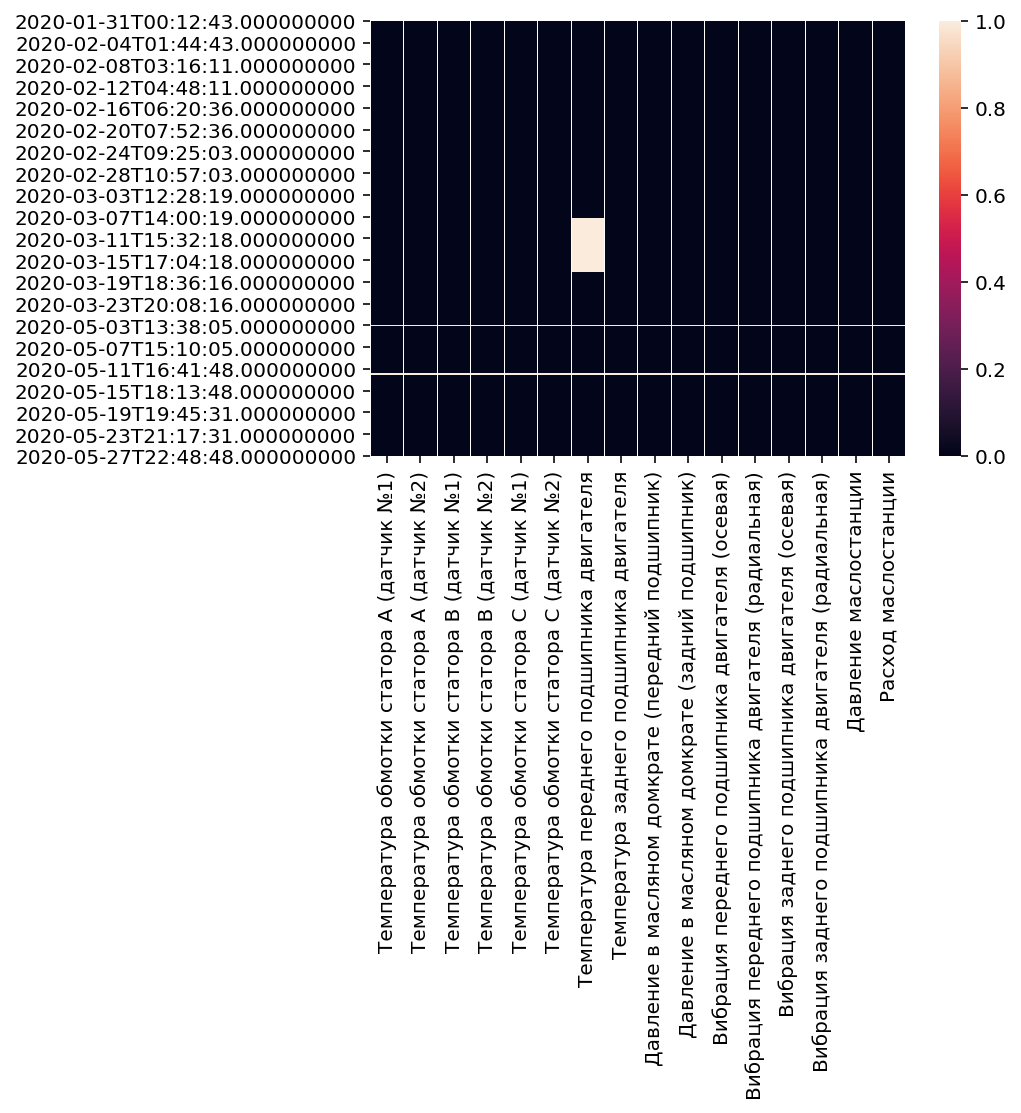

In [7]:
sns.heatmap(Data.isna())

In [8]:
Data.dropna(how='all', inplace=True)

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
Data = pd.DataFrame(imputer.fit_transform(Data), index=Data.index, columns=Data.columns)

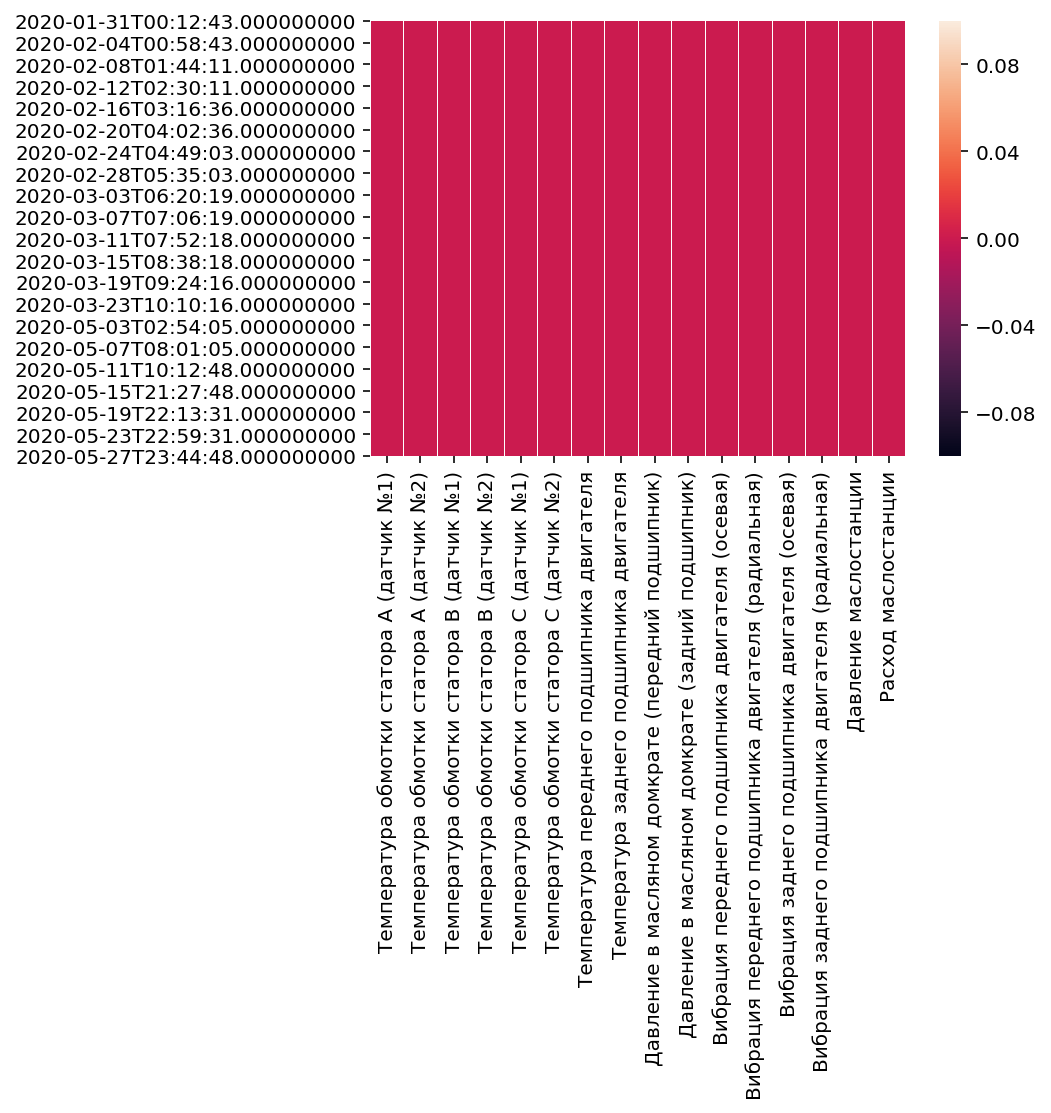

In [10]:
sns.heatmap(Data.isna())

## Таргет

In [11]:
# Берем таргет из журнальных данных

Data['target'] = 0
Data['target_dscr'] = "Норма"

for start, end, dscr in stops_data[np.invert(stops_data.description.isin([
        "Технологические плановые : Межплавочный период",
        ]))]\
        [['start_datetime', 'end_datetime', 'description']].values:
    
    Data['target'][(Data.index >= start) & (Data.index <= end)] = 1
    Data['target_dscr'][(Data.index >= start) & (Data.index <= end)] = dscr

In [12]:
# Добавляем таргет по минимумам вибрации

Data["target"][(Data["Вибрация заднего подшипника двигателя (осевая)"] < 5.0)
             & (Data["Вибрация заднего подшипника двигателя (радиальная)"] < 5.0)] = 1

In [13]:
def SetShiftTarget(Data, delta):
    """
    Сдвигает изначальный таргет на delta шагов назад
    Шаг дискретизации по времени : 5 минут
    """
    Data["shift_target"] = deepcopy(Data.target.shift(-delta, fill_value=0).values)
    Data["shift_target"] = Data.shift_target.astype(int)
    return Data

In [14]:
# Смещаем на 120 шагов (здесь минут) = 2 часа

Data = SetShiftTarget(Data, 120)

## Init Features

In [55]:
ValData = deepcopy(Data[Data.index < "2020-05"])
ExamData = deepcopy(Data[Data.index >= "2020-05"])

In [56]:
X = ValData.drop(['target', 'target_dscr', 'shift_target'], axis=1)
y = ValData['shift_target']

Exam_X = ExamData.drop(['target', 'target_dscr', 'shift_target'], axis=1)
Exam_y = ExamData['shift_target']

## Нормализация

In [57]:
from sklearn.preprocessing import StandardScaler

# Normalize X
ss = StandardScaler()

X = pd.DataFrame(ss.fit_transform(X),
                 index=X.index,
                 columns=X.columns)

Exam_X = pd.DataFrame(ss.fit_transform(Exam_X),
                      index=Exam_X.index,
                      columns=Exam_X.columns)

In [71]:
X_to_CNN = X.values.reshape(-1, X.shape[1])
Exam_X_to_CNN = Exam_X.values.reshape(-1, Exam_X.shape[1])

y_to_CNN = y.values
Exam_y_to_CNN = Exam_y.values

In [72]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Flatten, Dropout, Reshape

In [66]:
num_sensors = X_to_CNN.shape[1]
TIME_PERIODS = 120
BATCH_SIZE = 16
EPOCHS = 10

model_m = Sequential()
model_m.add(Conv1D(100, 6, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 6, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(Conv1D(160, 6, activation='relu'))
model_m.add(GlobalAveragePooling1D(name='G_A_P_1D'))
model_m.add(Dropout(0.5))
model_m.add(Dense(2, activation='softmax'))

print(model_m.summary())
model_m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 115, 100)          9700      
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 110, 100)          60100     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 36, 100)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 31, 160)           96160     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 26, 160)           153760    
_________________________________________________________________
G_A_P_1D (GlobalAveragePooli (None, 160)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 160)             

In [65]:
history = model_m.fit(X_to_CNN,
                      y_to_CNN,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=0.2,
                      verbose=2)

Epoch 1/10


ValueError: in user code:

    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /opt/miniconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_12 is incompatible with the layer: expected axis -1 of input shape to have value 16 but received input with shape [None, 16, 1]


<div class = "alert alert-block alert-danger">

<b>Пофиксить ошибку размерности входного X</b>

</div>

# EXAMPLE

In [68]:
path = "../Probe_Data/data/"

label = pd.read_csv(path+'profile.txt', sep='\t', header=None)
label.columns = ['Cooler','Valve','Pump','Accumulator','Flag']
data = ['TS1.txt','TS2.txt','TS3.txt','TS4.txt']
df = pd.DataFrame()
for txt in data:
    read_df = pd.read_csv(path+txt, sep='\t', header=None)
    df = df.append(read_df)

In [69]:
df

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,35.570,35.492,35.469,35.422,35.414,35.320,35.227,35.242,35.160,35.176,...,36.008,35.984,35.996,36.039,36.008,36.008,36.094,36.102,36.090,36.152
1,36.156,36.094,35.992,36.008,35.992,35.902,35.824,35.820,35.727,35.727,...,37.328,37.324,37.340,37.332,37.316,37.410,37.418,37.422,37.488,37.477
2,37.488,37.391,37.340,37.312,37.223,37.145,37.059,36.973,36.898,36.879,...,38.457,38.461,38.457,38.469,38.469,38.555,38.527,38.543,38.527,38.621
3,38.633,38.535,38.469,38.379,38.297,38.223,38.125,38.062,37.977,37.969,...,39.441,39.363,39.367,39.457,39.461,39.461,39.473,39.441,39.453,39.461
4,39.461,39.461,39.375,39.281,39.203,39.113,39.043,38.969,38.875,38.883,...,40.324,40.320,40.312,40.340,40.320,40.387,40.391,40.391,40.387,40.391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,30.383,30.375,30.379,30.363,30.367,30.391,30.383,30.363,30.375,30.402,...,30.383,30.395,30.406,30.383,30.406,30.422,30.402,30.395,30.402,30.379
2201,30.367,30.375,30.441,30.457,30.441,30.445,30.457,30.469,30.457,30.480,...,30.395,30.391,30.402,30.383,30.391,30.406,30.395,30.391,30.406,30.375
2202,30.375,30.375,30.367,30.375,30.367,30.375,30.379,30.367,30.367,30.391,...,30.480,30.484,30.480,30.488,30.480,30.480,30.484,30.395,30.480,30.379
2203,30.379,30.367,30.379,30.363,30.375,30.379,30.379,30.379,30.375,30.391,...,30.418,30.395,30.402,30.406,30.406,30.406,30.402,30.391,30.406,30.375
